### Import packages

In [159]:
import enchant
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import sys

In [151]:
# Install large model

#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

# Do not use

In [152]:
# Install medium model
#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

### Load and subset data

In [153]:
df = pd.read_csv("/home/domib/code/dominik-bulla/g0zzy/stress_sense/raw_data/Combined Data.csv", encoding="latin1")

In [154]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [197]:
stress_posts = df[df['status'].isin(['Stress','Anxiety','Depression'])]
#stress_posts = df[df['status'].isin(['Stress','Anxiety'])]
print(stress_posts.shape)
print(stress_posts.columns)
print(stress_posts.dtypes)
stress_posts.head()

(21961, 3)
Index(['Unnamed: 0', 'statement', 'status'], dtype='object')
Unnamed: 0     int64
statement     object
status        object
dtype: object


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


### Text Preprocessing

In [241]:
### lowercase
### dealing with numbers, punctuation, and symbols
### splitting
### tokenizing
### removing "stopwords"
### lemmatizing

nlp = spacy.load("en_core_web_md", disable=["ner", "parser", "textcat"])

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language_model=nlp, min_len=1):
        self.nlp = language_model
        self.min_len = min_len  # optional length filter

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(x) for x in X]

    def _preprocess(self, text):
        # Missing values
        if text is None:
            return []
        if not isinstance(text, str):
            text = str(text)

        # lower case
        text = text.strip().lower()
        if not text:
            return []

        # dealing with numbers, punctuation, and symbols/stopwords/lemmatizing
        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha and not tok.is_stop
        ]

        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha
            and not tok.is_stop
            and len(tok) > 2         # drop very short leftovers
            and tok.lemma_ not in {"don", "t", "m"}  # custom contraction cleanup
        ]

        # Optional: drop very short results
        if len(tokens) < self.min_len:
            return []
        return tokens

text_pipeline = Pipeline([
    ("preprocessor", TextPreprocessor())
])


In [242]:
processed = text_pipeline.fit_transform(stress_posts["statement"])
processed = list(processed)  # in case it's a numpy array
stress_posts = stress_posts.copy()
stress_posts["processed_tokens"] = pd.Series(processed, index=stress_posts.index, dtype=object)

### Text vectorizing

In [273]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: x,     # take the list of tokens "as is"
    preprocessor=lambda x: x,  # don’t lowercase/clean again
    lowercase=False,
    ngram_range=(2, 2),
    max_features=1000,
    token_pattern=None
)

tokens = stress_posts["processed_tokens"].apply(lambda x: x if isinstance(x, list) else [])

vectorized_messages = tfidf.fit_transform(tokens)
vectorized_messages = pd.DataFrame(
    vectorized_messages.toarray(),
    columns = tfidf.get_feature_names_out()
)

### Finding best model

In [274]:
scores = []
perplexities = []
topics_range = range(3, 21, 3)

for k in topics_range:
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=20,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(vectorized_messages)
    scores.append(lda.score(vectorized_messages))
    perplexities.append(lda.perplexity(vectorized_messages))

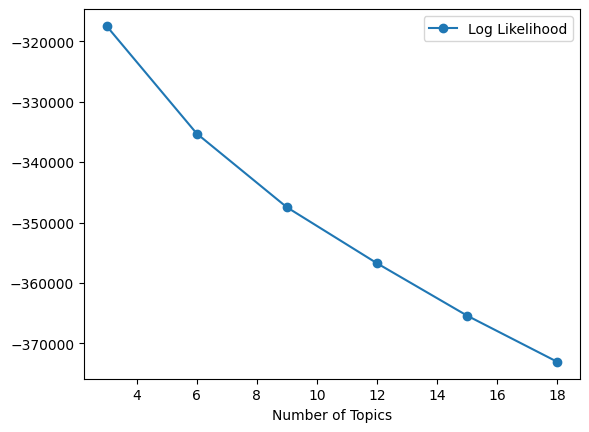

In [276]:
%matplotlib inline

plt.plot(topics_range, scores, marker="o", label="Log Likelihood")
#plt.plot(topics_range, perplexities, marker="x", label="Perplexity")
plt.xlabel("Number of Topics")
plt.legend()
plt.show()


### Train LDA Model

In [296]:
n_components = 6
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100)
lda_model.fit(vectorized_messages)
topics_mixture = lda_model.transform(vectorized_messages)

### link back to original dataframe 

In [297]:
def link_back(topics_mixture, stress_posts):

    topic_cols = [f"topic_{i}" for i in range(topics_mixture.shape[1])]
    topic_df = pd.DataFrame(topics_mixture, index=stress_posts.index, columns=topic_cols)

    stress_posts = stress_posts.copy()
    stress_posts["dominant_topic"] = topic_df.values.argmax(axis=1)
    stress_posts["dominant_weight"] = round(topic_df.max(axis=1),2)
    stress_posts["solution"] = np.where(
        stress_posts["dominant_weight"] > round(1/6,2), 1, 0
    )

    return stress_posts

In [298]:
stress_posts_6 = link_back(topics_mixture, stress_posts)

In [299]:
### proportion of proper solutions
print(round(np.multiply(stress_posts_6.solution.value_counts(normalize=True)[1], 100),2))


85.84


In [304]:
stress_posts_6[
    (stress_posts_6['status'] == "Depression") &
    (stress_posts_6['solution'] == 1)
]["dominant_topic"].value_counts()


dominant_topic
1    5127
2    2834
4    1866
0    1481
5    1317
3    1018
Name: count, dtype: int64

In [284]:
def print_topics(lda_model, vectorizer, top_words):
    topic_word_mixture = pd.DataFrame(
        lda_model.components_,
        columns = tfidf.get_feature_names_out()
    )
    n_components = topic_word_mixture.shape[0]

    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_word_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)

        print(round(topic_df,3))

In [285]:
print_topics(lda_model, tfidf, 10)

----------
For topic 0, here are the the top 10 words with weights:
panic attack      235.720
health anxiety    222.095
week ago           99.570
month ago          98.530
day ago            76.528
go away            74.933
go doctor          74.835
heart attack       71.993
feel like          69.615
chest pain         69.335
Name: 0, dtype: float64
----------
For topic 1, here are the the top 10 words with weights:
feel like        710.293
make feel        120.864
look like        107.537
feel bad          98.093
mental health     91.821
feel way          89.577
know feel         85.955
like go           78.904
like feel         76.656
time feel         75.843
Name: 1, dtype: float64
----------
For topic 2, here are the the top 10 words with weights:
feel like      198.736
year old       131.460
high school    124.962
year ago       101.600
good friend     90.616
video game      87.266
day day         79.060
hard time       71.651
new job         68.251
long time       65.707
Name: 2,